<a href="https://colab.research.google.com/github/GabrielMartinHsia/FlightPlan/blob/main/WindCorrectionAngle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A `TripLeg()` Class

In [2]:
class TripLeg():
  def __init__(self, Distance, WindDirection, WindSpeed, TrueCourse, TAS, MagVar=0, MagDev=0, BurnRate=10, TroubleShooting=False):
    self.TroubleShooting = TroubleShooting
    self.Distance = Distance
    self.WindDirection = WindDirection #for display only
    self.WindDir_comp = (WindDirection + 180)%360 #for computation (180 degrees from entered "WindDirection") because in aviation, wind direction is the direction the wind is coming *from*, not the direction the vector is pointing.
    self.WindSpeed = WindSpeed
    self.TrueCourse = TrueCourse
    self.TAS = TAS
    self.MagVar = MagVar
    self.MagDev = MagDev
    self.BurnRate = BurnRate

    #call functions to calculate critical course information
    self.getInnerWindAngle()
    self.getGroundSpeed()
    self.getWindCorrectionAngle()

    #now call functions to calculate ETE and FuelBurn
    self.toMagnetic()
    self.estimatedTimeEnroute()
    self.estimatedFuelBurn()

  def getInnerWindAngle(self):
    '''
    given the wind angle (0-360) and course heading (0-360), determine the inside angle between the two vectors
    ref:
    https://stackoverflow.com/questions/1878907/how-can-i-find-the-smallest-difference-between-two-angles-around-a-point

    '''
    a = self.TrueCourse - self.WindDir_comp
    self.alpha = (a + 180)%360 - 180

  def getGroundSpeed(self):
    '''
    Use the Law of Cosines and the quadratic equation to solve groundspeed
    (i.e., the length of the "course" side of the wind triangle) given the
    inner angle (alpha) between the wind and the course (both known directions),
    and the known magnitudes TAS and WindSpeed. Law of Cosines gives a quadratic
    eqn in groundspeed. Two solutions: the positive one is your groundspeed...
    (... unless, perhaps, the wind speed is greater than your TAS, in which case
     you should probably not be flying.)
    ref: https://www.pilotsofamerica.com/community/threads/how-to-solve-the-wind-triangle.122389/

    '''
    a = 1
    b = -2 * self.WindSpeed * np.cos(np.deg2rad(self.alpha))
    c = self.WindSpeed**2 - self.TAS**2
    result = ((-b + np.sqrt(b**2 - 4*a*c)) / 2 / a, (-b - np.sqrt(b**2 - 4*a*c) / 2 / a))
    if self.TroubleShooting:
      print(f'coefficient "a":\t{a}')
      print(f'coefficient "b":\t{b}')
      print(f'coefficient "C":\t{c}')
      print(f'b**2:\t\t{b**2}')
      print(f'-4*a*c:\t\t{-4*a*c}')
      print(f'quadratic result:\t{result}')
    if result[0] >= 0:
      self.GroundSpeed = result[0]
    elif result[1] >= 0:
      self.GroundSpeed = result[1]
    else:
      print("Error: no positive solution for groundspeed")

  def getWindCorrectionAngle(self):
    '''
    With GroundSpeed now known, we can use the Law of Cosines again to determine the WindCorrectionAngle
    ref: https://www.pilotsofamerica.com/community/threads/how-to-solve-the-wind-triangle.122389/
    '''
    if self.alpha <= 0:
      self.WCA = -np.rad2deg(np.arccos((self.WindSpeed**2 - self.TAS**2 - self.GroundSpeed**2)/(-2 * self.TAS * self.GroundSpeed)))
    if self.alpha >= 0:
      self.WCA = np.rad2deg(np.arccos((self.WindSpeed**2 - self.TAS**2 - self.GroundSpeed**2)/(-2 * self.TAS * self.GroundSpeed)))
    self.TrueHeading = self.TrueCourse + self.WCA

  def printParams(self):
    print(f'GIVEN:')
    print(f'\tWindDirection:\t{self.WindDirection}') #just regurgitating entered value
    print(f'\tWindSpeed:\t{self.WindSpeed}')
    print(f'\tCourse:\t\t{self.TrueCourse}')
    print(f'\tTAS:\t\t{self.TAS}')
    print(f'CALCULATED:')
    print(f'\tGroundSpeed:\t{self.GroundSpeed}')
    print(f'\tWindCorrection:\t{self.WCA}')
    print(f'\tTrueHeading:\t{self.TrueHeading}')
    if self.TroubleShooting:
      print(f'alpha:\t{self.alpha}')
      print(f'Numerator:\t{self.WindSpeed**2} - {self.TAS**2} - {self.GroundSpeed**2} = {self.WindSpeed**2 - self.TAS**2 - self.GroundSpeed**2}')
      print(f'Denominator:\t{-2} * {self.TAS} * {self.GroundSpeed} = {-2 * self.TAS * self.GroundSpeed}')

  def showWindTriangle(self):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.arrow(0,0, np.deg2rad(self.TrueCourse), self.GroundSpeed, color='blue', label='Groundspeed & Track')
    ax.arrow(0,0, np.deg2rad(self.TrueHeading), self.TAS, color='green', label='True Airspeed & Heading')
    ax.arrow(0,0, np.deg2rad(self.WindDir_comp), self.WindSpeed, color='red', label='Wind') #plot the wind *vector*, opposite the entered WindDirection value
    ax.legend(bbox_to_anchor=(0.1, 0.1), prop={'size':6})

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    plt.tight_layout()
    plt.show()

  def toMagnetic(self):
    self.MagCourse = self.TrueCourse + self.MagVar + self.MagDev
    self.MagHeading = self.TrueHeading + self.MagVar + self.MagDev

  def estimatedTimeEnroute(self):
    self.ETE = self.Distance / self.GroundSpeed * 60 #[minutes]

  def estimatedFuelBurn(self):
    self.FuelBurn = self.BurnRate * (self.ETE / 60)


# Read Input Data From Spreadsheet

In [3]:
path = '/content/drive/My Drive/Flight/LearningToFly/ColabFlightPlan'
f = glob.glob(path + '/FlightPlanColabTest.xlsx')
data = pd.read_excel(f[0], header=0)
data

,Checkpoint,Distance,Altitude,Wind Direction,Wind Speed,True Course,True Airspeed,Mag Var,Mag Dev,Burn Rate
0,chaad,45,6500,208,20,335,74,-11.0,-2,10
1,ryann,24,8500,250,18,280,96,-11.0,0,8
2,norwek,60,8500,355,14,318,96,-11.5,0,8
3,anderson,37,8500,80,28,290,96,-11.5,1,8
4,JLI,18,6500,65,37,350,96,-12.0,-2,8
5,cooper,21,4500,108,12,95,96,-12.0,0,8


# Append Calculated Data


LEG TO: chaad
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [208, 20, 335, 74]
CALCULATED:	WCA=-12.5	GS=84.3


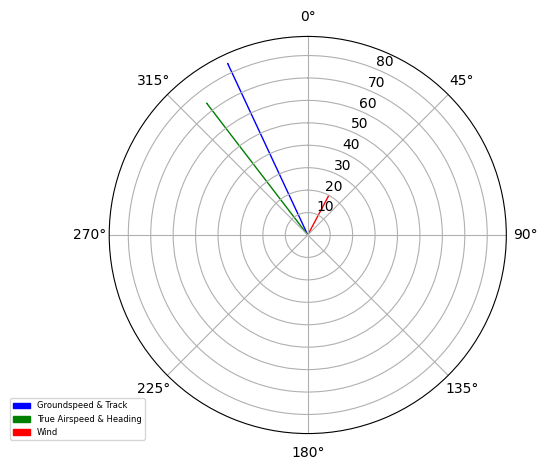


LEG TO: ryann
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [250, 18, 280, 96]
CALCULATED:	WCA=-5.4	GS=80.0


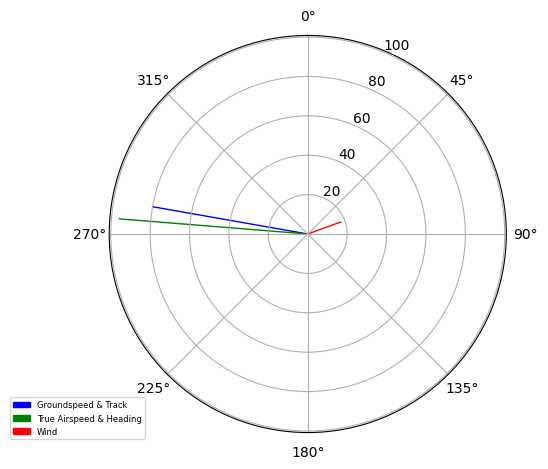


LEG TO: norwek
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [355, 14, 318, 96]
CALCULATED:	WCA=5.0	GS=84.4


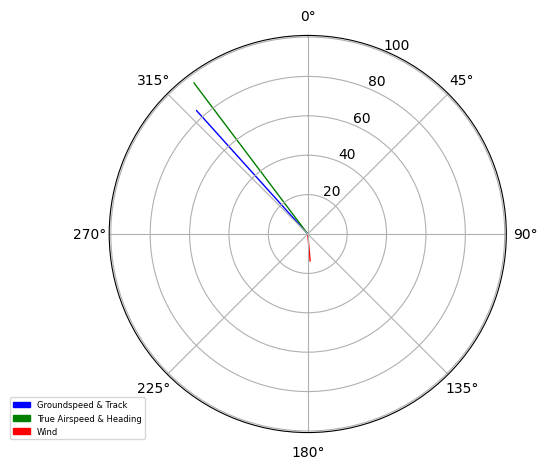


LEG TO: anderson
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [80, 28, 290, 96]
CALCULATED:	WCA=8.4	GS=119.2


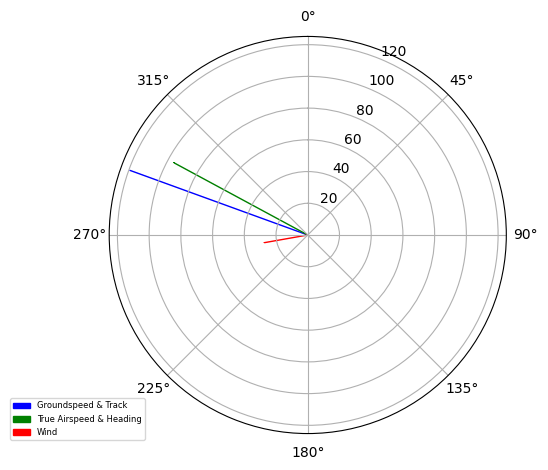


LEG TO: JLI
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [65, 37, 350, 96]
CALCULATED:	WCA=21.9	GS=79.5


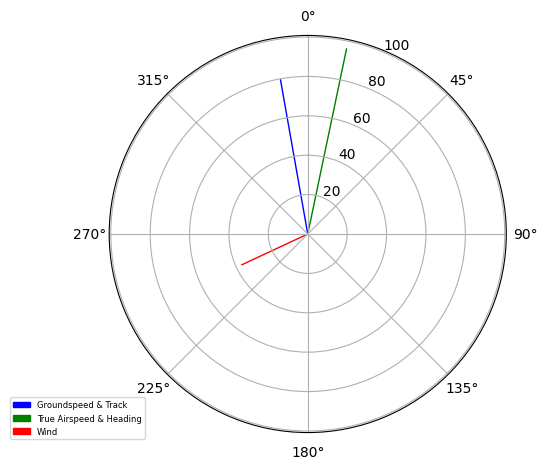


LEG TO: cooper
WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: [108, 12, 95, 96]
CALCULATED:	WCA=1.6	GS=84.3


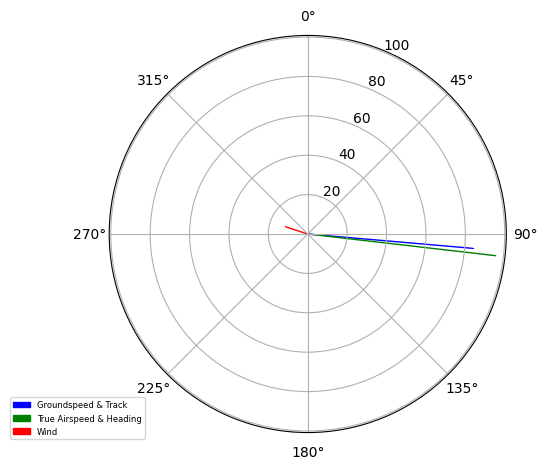


TOTALS:
Est Time Enroute:	139.82 minutes 
Est Fuel Burn:		19.71 gallons


In [4]:
data = pd.read_excel(f[0], header=0)
calculated = {'WCA':[],
              'GS':[],
              'Magnetic Course':[],
              'Magnetic Heading':[],
              'ETE':[],
              'Est Fuel Burn':[]
              }
for i in range(len(data)):
  row = data.loc[i]
  input_params = [#these params must be in the correct order as args to TripLeg() call below...
                  row['Distance'],
                  row['Wind Direction'],
                  row['Wind Speed'],
                  row['True Course'],
                  row['True Airspeed'],
                  row['Mag Var'],
                  row['Mag Dev'],
                  row['Burn Rate']
                ]
  L = TripLeg(*input_params)
  print(f'\nLEG TO: {row.Checkpoint}')
  print(f'WCA INPUT DATA [WindDir, WindSpd, TruCourse, TAS]: {input_params[1:5]}') #did *input_params for brevity here
  print(f'CALCULATED:\tWCA={L.WCA:.1f}\tGS={L.GroundSpeed:.1f}')
  L.showWindTriangle()
  calculated['WCA'].append(L.WCA)
  calculated['GS'].append(L.GroundSpeed)
  calculated['Magnetic Course'].append(L.MagCourse)
  calculated['Magnetic Heading'].append(L.MagHeading)
  calculated['ETE'].append(L.ETE)
  calculated['Est Fuel Burn'].append(L.FuelBurn)

data = data.join(pd.DataFrame(calculated))
print(f"\nTOTALS:\nEst Time Enroute:\t{data.ETE.sum():.2f} minutes \nEst Fuel Burn:\t\t{data['Est Fuel Burn'].sum():.2f} gallons")


In [5]:
data

,Checkpoint,Distance,Altitude,Wind Direction,Wind Speed,True Course,True Airspeed,Mag Var,Mag Dev,Burn Rate,WCA,GS,Magnetic Course,Magnetic Heading,ETE,Est Fuel Burn
0,chaad,45,6500,208,20,335,74,-11.0,-2,10,-12.465249,84.291906,322.0,309.534751,32.031545,5.338591
1,ryann,24,8500,250,18,280,96,-11.0,0,8,-5.379379,79.988737,269.0,263.620621,18.002535,2.400338
2,norwek,60,8500,355,14,318,96,-11.5,0,8,5.035024,84.448661,306.5,311.535024,42.629450,5.683927
3,anderson,37,8500,80,28,290,96,-11.5,1,8,8.385539,119.222392,279.5,287.885539,18.620663,2.482755
4,JLI,18,6500,65,37,350,96,-12.0,-2,8,21.856541,79.523110,336.0,357.856541,13.580958,1.810794
5,cooper,21,4500,108,12,95,96,-12.0,0,8,1.611306,84.269599,83.0,84.611306,14.952011,1.993602
